In [1]:
from os import path
import pickle

from astropy.constants import m_p
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
from astropy.io import fits

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

In [2]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, z_sun=0*u.pc, 
                                    galcen_v_sun=coord.CartesianDifferential(11.1, 232.24, 7.25, unit=u.km/u.s))

In [3]:
mike_data = Table.read('../data/mike_final.fits')
mike_data['pw1_id'] = [int(x.strip()[-2:]) if 'pw' in x else 9999 for x in mike_data['NAME']]

data = Table.read('../output/pw1-region-data-joined.fits')
data['pw1_id'] = [int(x.strip()[-2:]) if 'PW' in x else 9999 for x in data['pw1_name']]

In [4]:
tbl = join(data, mike_data, keys='pw1_id')
tbl = tbl[tbl['pw1_name'] != '']

In [5]:
all_c = coord.SkyCoord(ra=tbl['ra']*u.deg,
                       dec=tbl['dec']*u.deg,
                       distance=28.7*u.kpc,
                       pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                       pm_dec=tbl['pmdec']*u.mas/u.yr,
                       radial_velocity=tbl['VHELIO']*u.km/u.s)

Mean cluster kinematics determined using the velocity model in `Kinesis-model.ipynb`

In [6]:
avg_c = coord.SkyCoord(ra=178.94196721*u.deg, 
                       dec=-29.41088227*u.deg, 
                       distance=28.7*u.kpc,
                       pm_ra_cosdec=-0.52*u.mas/u.yr,
                       pm_dec=0.42*u.mas/u.yr,
                       radial_velocity=249.1*u.km/u.s).transform_to(galcen_frame)

In [7]:
galcen = avg_c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)
pot = gp.MilkyWayPotential(halo=dict(c=0.9))

Tidal radius at this distance:

In [8]:
(1e3*u.Msun / pot.mass_enclosed(w0)[0])**(1/3) * w0.pos.norm().to(u.pc)

<Quantity 42.6533126 pc>

Compute the orbit in a Milky Way model without drag by integrating backwards in time:

In [27]:
lmc_w0 = gd.PhaseSpacePosition(pos=[-1.1, -41.1, -27.9] * u.kpc,
                               vel=[-57., -226, 221] * u.km/u.s)

In [30]:
def F_nodrag(t, w):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    # Force from the LMC itself
    lmc = gp.HernquistPotential(m=2e11*u.Msun, c=12.40*u.kpc, 
                                units=galactic, origin=q[1])
    lmc_acc = lmc.acceleration(q[0]).value[:, 0]
    acc[:, 0] = acc[:, 0] + lmc_acc
    
    return np.vstack((p.T, acc))

In [47]:
integrator = gi.DOPRI853Integrator(F_nodrag, func_units=galactic)
orbits_nodrag = integrator.run(gd.combine((w0, lmc_w0)), 
                               dt=-1, t1=0, t2=-age)
orbit_nodrag = orbits_nodrag[:, 0]
orbit_lmc = orbits_nodrag[:, 1]

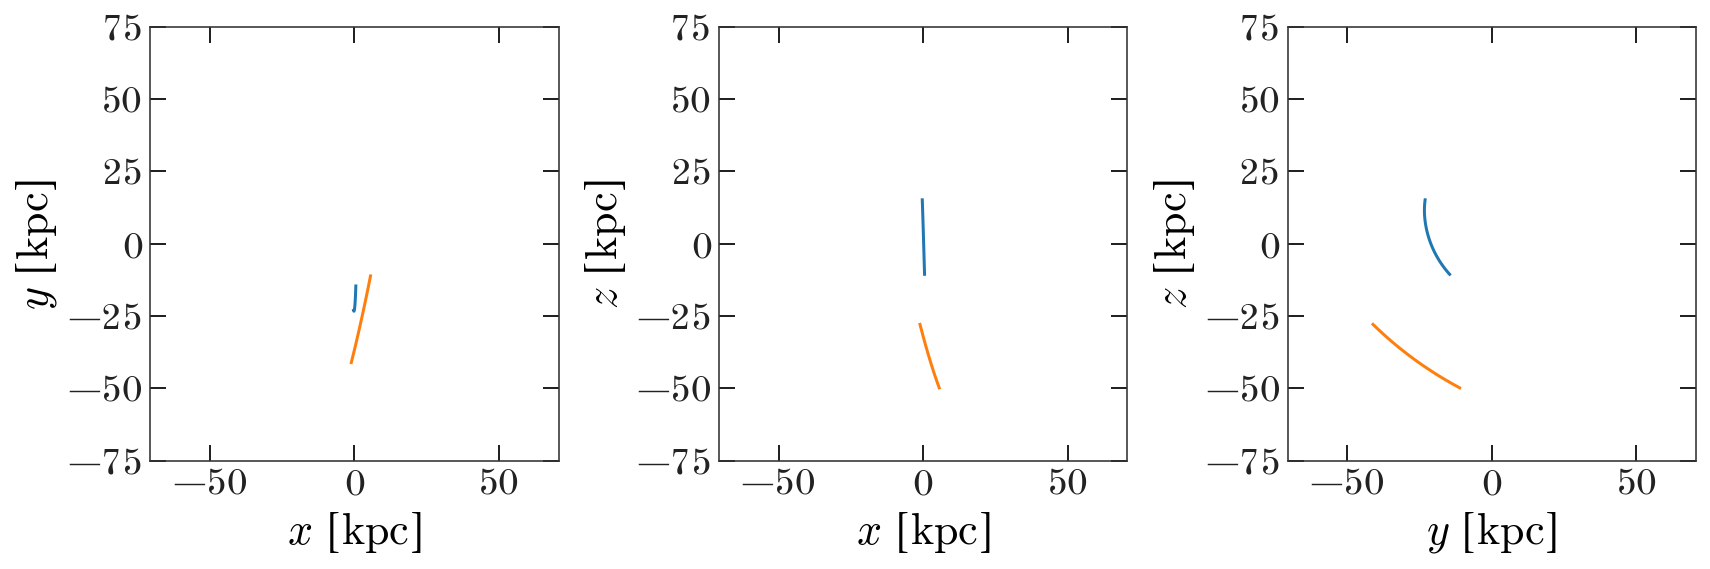

In [48]:
fig = orbit_nodrag.plot()
_ = orbit_lmc.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)

Find the "intital conditions" at the inferred age of the cluster (-116 Myr):

In [51]:
age = 116 * u.Myr
w0_birth = orbit_nodrag[-1]
t_birth = orbit_nodrag.t[-1]
t_birth

<Quantity -116. Myr>

Estimate the drag acceleration by assuming a cloud surface density, milky way gas density, then use:

$$
a_{\rm ram} = \rho_{\rm MW} \, v^2 \, m_H^{-1} \, \Sigma_{cloud}^{-1}
$$

For the cloud surface density, try plugging in the column density of the LA gas. David gave me:

In [52]:
# col_dens = 7 * 10**19 * 1 / u.cm**2
# new value (2019-08-06)
col_dens = 1.5 * 10**20 * 1 / u.cm**2
surf_dens = (col_dens * m_p).to_value(u.Msun / u.kpc**2)
(col_dens * m_p).to(u.Msun / u.pc**2)

<Quantity 1.20135097 solMass / pc2>

In [53]:
# for unit conversion
_dens_fac = m_p.to_value(u.Msun) * (1/u.cm**3).to_value(1/u.kpc**3)

In [83]:
Rsun = 8.1 # * u.kpc

# A model for the number density of the halo:
def n_mw_halo(r):
    # From Miller & Bregman 2013
    n0 = 0.46 # / u.cm**3
    rc = 0.35 # * u.kpc
    beta = 0.71
    return n0 * (1 + (r/rc)**2) ** (-1.5 * beta)


# A model for the number density of the disk:
# - Note: it flares as a function of radius, so need a 
#   function to compute the scale height at a given R
def hz(R):
    h0 = 0.15 # * u.kpc
    R0 = 9.8 # * u.kpc
    hz = h0 * np.exp((R-Rsun) / R0)
    return hz

def sigz(R):
    return 0.85 * hz(R)
    
def n_mw_disk(R, z):
    # From Kaberla review
    # s = sigz(R)
    s = hz(R)
    
    n0 = 0.9 # / u.cm**3
    Rn = 3.15 # * u.kpc
    
    # note: I added the z dependence
    # return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-0.5 * z**2 / s**2)
    return n0 * np.exp(-(R-Rsun)/Rn) * np.exp(-np.abs(z) / s)

In [84]:
# For playing around with a time-evolving surface density...ignore
def surf_dense_func(t, t1, t2, surf_dens0):
    surf_dens0 = np.log(surf_dens0)
    surf_densf = np.log(1.2) # see above
    m = (surf_densf - surf_dens0) / (t2 - t1)
    return np.exp(m * t + surf_densf)

$$
\Sigma_{\rm LA}(t) = \exp\left[\frac{\Sigma_f - \Sigma_0}{\tau} \, t + \Sigma_f\right]
$$

Fudge factors that we multiple the drag force by for the halo and disk terms:

In [88]:
magic_factor_halo = 1.
# magic_factor_disk = 0. # turn off the disk component
magic_factor_disk = 0.8

In [89]:
def F(t, w, f_halo, f_disk, coupling_factor):
    # position units are in kpc
    # velocity units here are in kpc/Myr
    x, y, z, vx, vy, vz = w
    
    q = np.stack((x, y, z), axis=1)
    p = np.stack((vx, vy, vz), axis=1)
    
    r = np.linalg.norm(q, axis=1)[0] # galcen distance
    R = np.sqrt(x**2 + y**2)[0] # cylindrical radius
    
    # compute acceleration from milky way:
    _t = np.array([0.])
    acc = -pot._gradient(q, _t).T
    
    surf_dens0 = 50. # Wong+2011
    surf_dens = 1e6 * surf_dense_func(t, -age.value, 0, surf_dens0)
    
    # compute drag acceleration    
    nn = f_halo * n_mw_halo(r) + f_disk * n_mw_disk(R, z[0])
    fac = (nn * _dens_fac) / surf_dens
    acc_drag = fac * np.sum(p[0:1]**2, axis=1) # rho / Sigma * v^2
    
    # in the direction opposite of motion
    acc_drag = -acc_drag * p[0:1] / np.sqrt(np.sum(p[0:1]**2, axis=1))
    acc_drag = acc_drag.T
    
    # ---
    
    # the Cartesian unit vector in the direction of galactic rotation 
    # at the current position of the orbit
    phi = np.arctan2(y[0], x[0])
    unit_vec = -np.array([-np.sin(phi), np.cos(phi), 0])
    
    # multiply by a gaussian so this only operates near the midplane
    acc_drag[:, 0] += coupling_factor * unit_vec * np.exp(-0.5 * z[0]**2 / sigz(R)**2)
    
    # ---
    # Force from the LMC itself
    lmc = gp.HernquistPotential(m=2e11*u.Msun, c=12.40*u.kpc, 
                                units=galactic, origin=q[1])
    lmc_acc = lmc.acceleration(q[0]).value[:, 0]
    acc[:, 0] = acc[:, 0] + lmc_acc
    acc[:, 0] += acc_drag[:, 0]
    
    return np.vstack((p.T, acc))

In [90]:
integrator = gi.DOPRI853Integrator(F, func_units=galactic,
                                   func_args=(magic_factor_halo, magic_factor_disk, 0))
orbits_drag = integrator.run(gd.combine((w0_birth, lmc_w0)), 
                             dt=5, t1=-age, t2=0)
orbit_drag = orbits_drag[:, 0]
orbit_lmc = orbits_drag[:, 1]

Text(0, 0.5, '$z$ [kpc]')

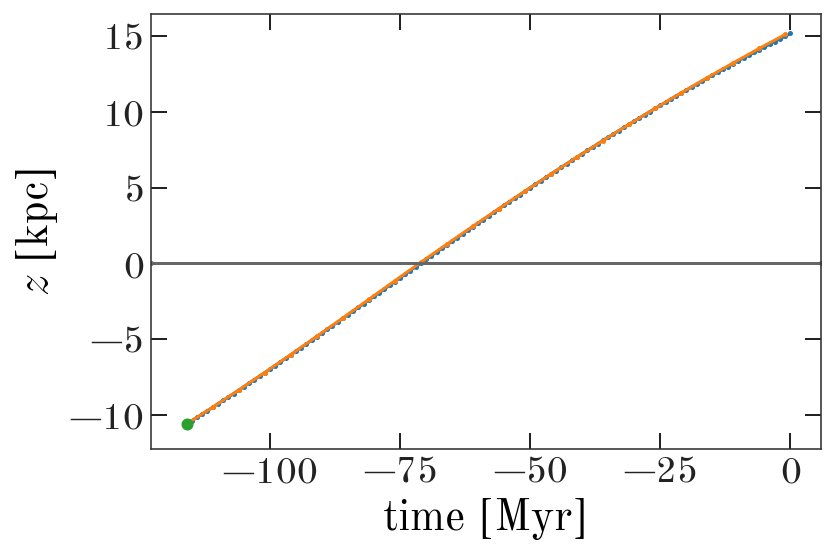

In [91]:
plt.plot(orbit_nodrag.t, orbit_nodrag.z)
plt.plot(orbit_drag.t, orbit_drag.z)
plt.scatter(t_birth, w0_birth.z, color='tab:green', zorder=100)

plt.axhline(0.)
plt.xlabel(r'time [Myr]')
plt.ylabel(r'$z$ [kpc]')

In [92]:
tbl = Table()
orbit_nodrag_c = orbit_nodrag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                             galactocentric_frame=galcen_frame)
tbl['L'] = orbit_nodrag_c.L
tbl['B'] = orbit_nodrag_c.B
tbl['distance'] = orbit_nodrag_c.distance
tbl['vlsr'] = orbit_nodrag_c.radial_velocity - 4*u.km/u.s
# tbl.write('../data/orbit-nodrag.fits')

Text(0, 0.5, '$z$ [kpc]')

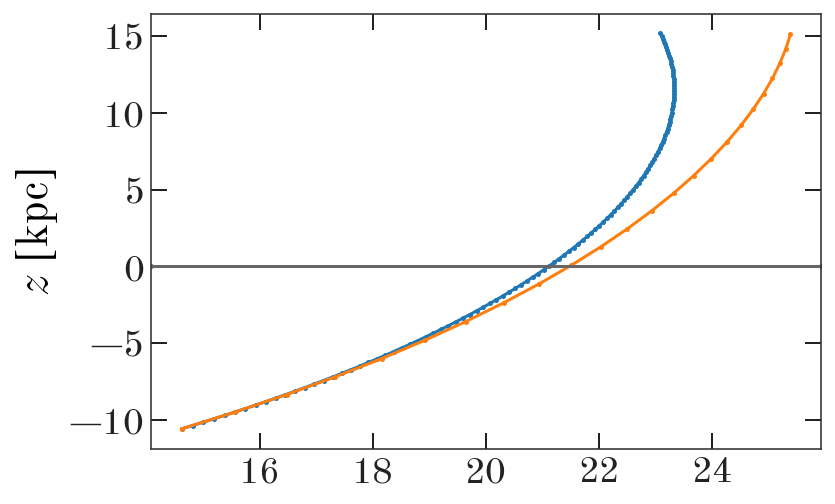

In [93]:
cyl_nodrag = orbit_nodrag.cylindrical
cyl_drag = orbit_drag.cylindrical
plt.plot(cyl_nodrag.rho, orbit_nodrag.z)
plt.plot(cyl_drag.rho, orbit_drag.z)
# plt.scatter(t_birth, w0_birth.z, color='tab:green', zorder=100)

plt.axhline(0.)
# plt.xlabel(r'time [Myr]')
plt.ylabel(r'$z$ [kpc]')

In [94]:
orbit_nodrag_c = orbit_nodrag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                             galactocentric_frame=galcen_frame)
orbit_drag_c = orbit_drag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                         galactocentric_frame=galcen_frame)

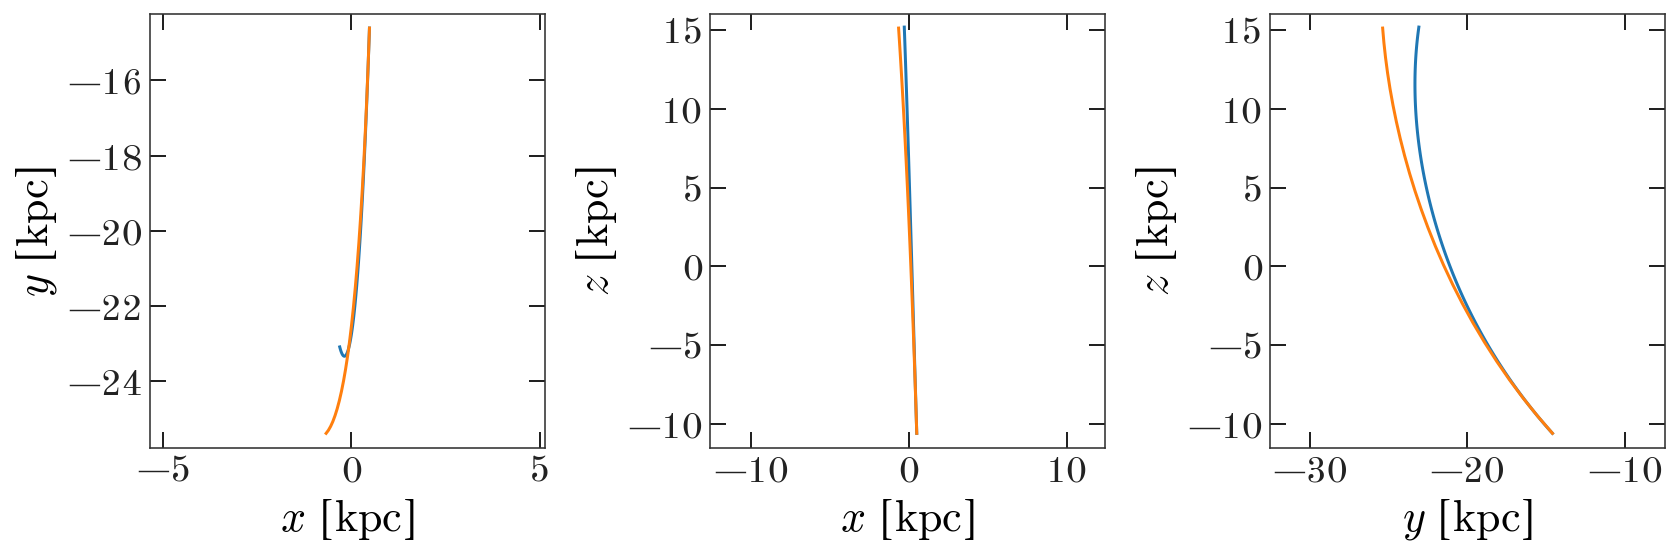

In [95]:
fig = orbit_nodrag.plot()
_ = orbit_drag.plot(axes=fig.axes)

Text(0, 0.5, '$RV$ [$\\mathrm{km\\,s^{-1}}$]')

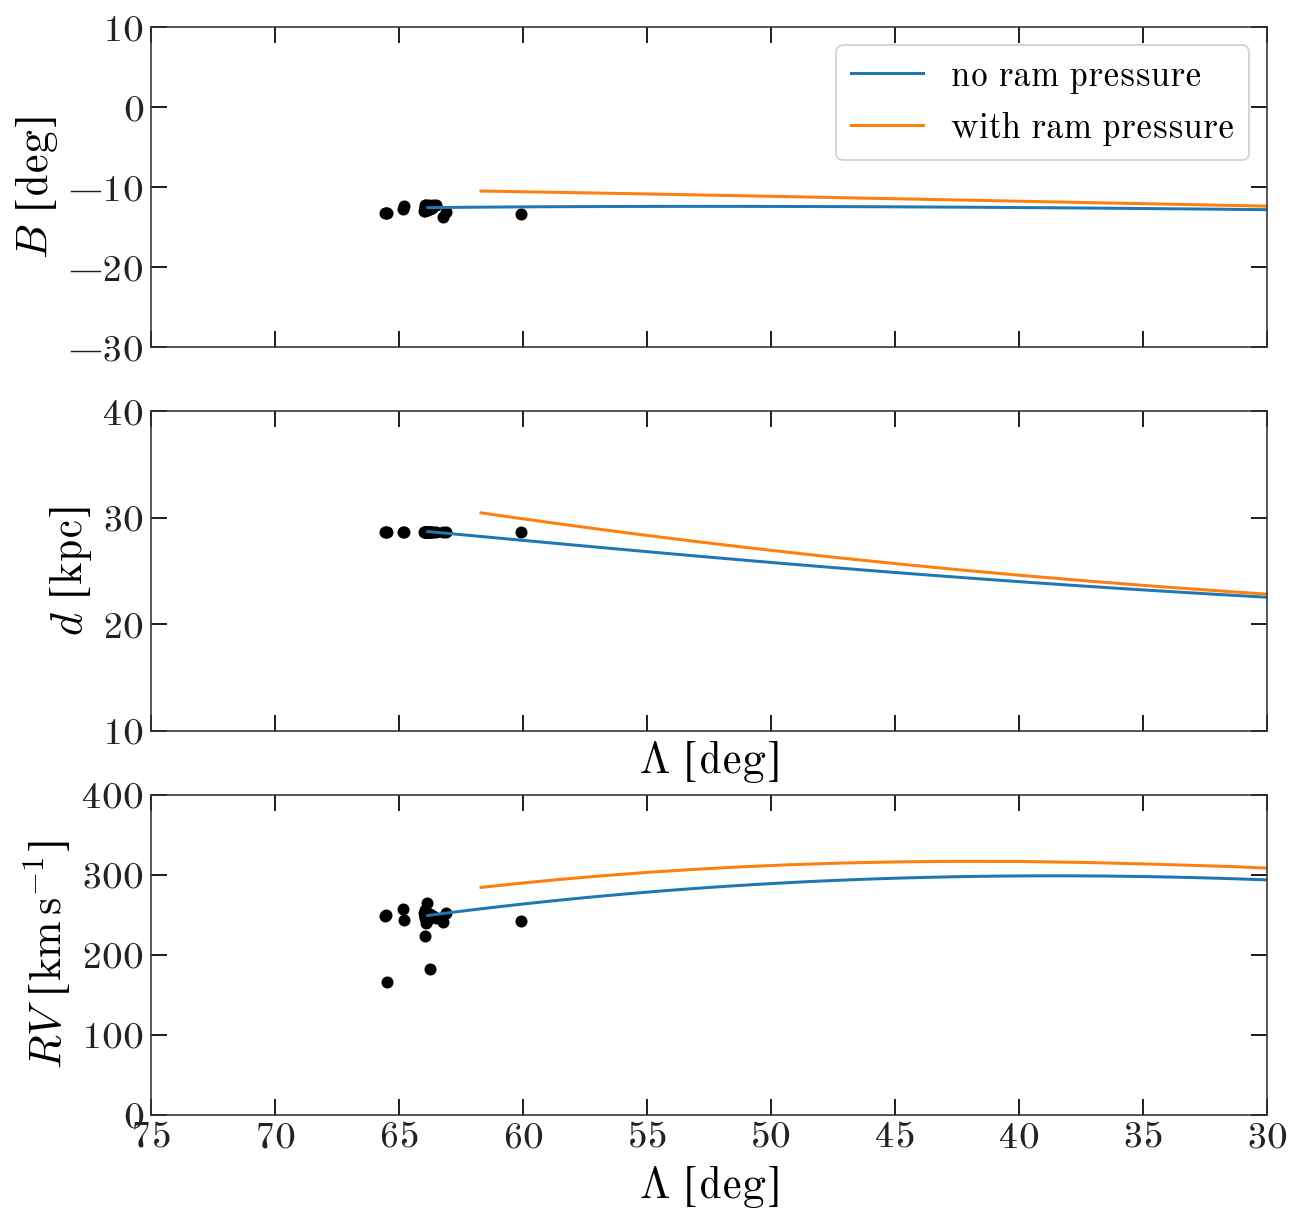

In [96]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True)

ax = axes[0]
mag_all_c = all_c.transform_to(gc.MagellanicStreamNidever08)
ax.scatter(mag_all_c.L.degree, mag_all_c.B.degree, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.B.degree, marker='', label='no ram pressure')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.B.degree, marker='', label='with ram pressure')

ax.legend(loc='best', fontsize=18)

ax.set_xlim(75, 30)
ax.set_ylim(-30, 10)

ax.set_ylabel(r'$B$ [deg]')

# ---

ax = axes[1]
ax.scatter(mag_all_c.L.degree, mag_all_c.distance.value, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.distance.value, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.distance.value, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(10, 40)

ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$d$ [kpc]')

# ---

ax = axes[2]
ax.scatter(mag_all_c.L.degree, mag_all_c.radial_velocity.value, marker='o', color='k')

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.radial_velocity.value, marker='')
ax.plot(orbit_drag_c.L.degree, orbit_drag_c.radial_velocity.value, marker='')

ax.set_xlim(75, 30)
ax.set_ylim(0, 400)

ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$RV$ [{:latex_inline}]'.format(u.km/u.s))

# fig.savefig('../plots/with-gas-disk.png', dpi=250)

---

In [97]:
from scipy.optimize import minimize
import emcee
from schwimmbad import MultiPool

In [98]:
L_fiducial = 53.7
L_sigma = 0.5

B_fiducial = -11.1
B_sigma = 1.5

rv_fiducial = 239
rv_sigma = 5

In [99]:
def lnnormal(x, mu, sigma):
    var = sigma**2
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

both_w0 = gd.combine((w0_birth, lmc_w0))
bounds=[(-5, 5), (-5, 5), (-30, 0)]

def lnprob(p):
    """p: log(magic_factor_halo, magic_factor_disk, coupling_factor)"""
    
    for i in range(len(p)):
        if not bounds[i][0] < p[i] < bounds[i][1]:
            return -np.inf
    
    args = np.exp(p)
    integrator = gi.DOPRI853Integrator(F, func_units=galactic, func_args=args)
    try:
        orbit_drag = integrator.run(both_w0, dt=6, t1=-age, t2=0)[:, 0]
    except:
        return -np.inf
    orbit_drag_c = orbit_drag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                             galactocentric_frame=galcen_frame)
        
    ll = 0.
    ll += lnnormal(orbit_drag_c.L.degree[-1], L_fiducial, L_sigma)
    ll += lnnormal(orbit_drag_c.B.degree[-1], B_fiducial, B_sigma)
    ll += lnnormal(orbit_drag_c.radial_velocity.value[-1], rv_fiducial, rv_sigma)
    
    # make prior uniform in the non-log parameters
    # ll += np.sum(p)
    ll += np.sum(p[:2])
    
    return ll

def minfunc(p):
    return -lnprob(p)

In [100]:
res = minimize(minfunc, np.log([1., 1., 1e-2]), method='L-BFGS-B',
               bounds=bounds)

In [101]:
res

      fun: 213.06333728943164
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.58751765, -40.94337385,  72.99379376])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 1
   status: 0
  success: True
        x: array([ 0.        ,  0.        , -4.60517019])

In [105]:
cache_filename = 'orbit_sampler_expz.pkl'
if not path.exists(cache_filename):
    nwalkers = 64
    ndim = len(res.x)
    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        p0s = emcee.utils.sample_ball(res.x, [1e-3]*ndim, nwalkers)
        pos, *_ = sampler.run_mcmc(p0s, 256)
        sampler.reset()
        pos, *_ = sampler.run_mcmc(pos, 256)
    
    sampler.pool = None
    with open(cache_filename, 'wb') as f:
        pickle.dump(sampler, f)
        
else:
    with open(cache_filename, 'rb') as f:
        sampler = pickle.load(f)

KeyboardInterrupt: 

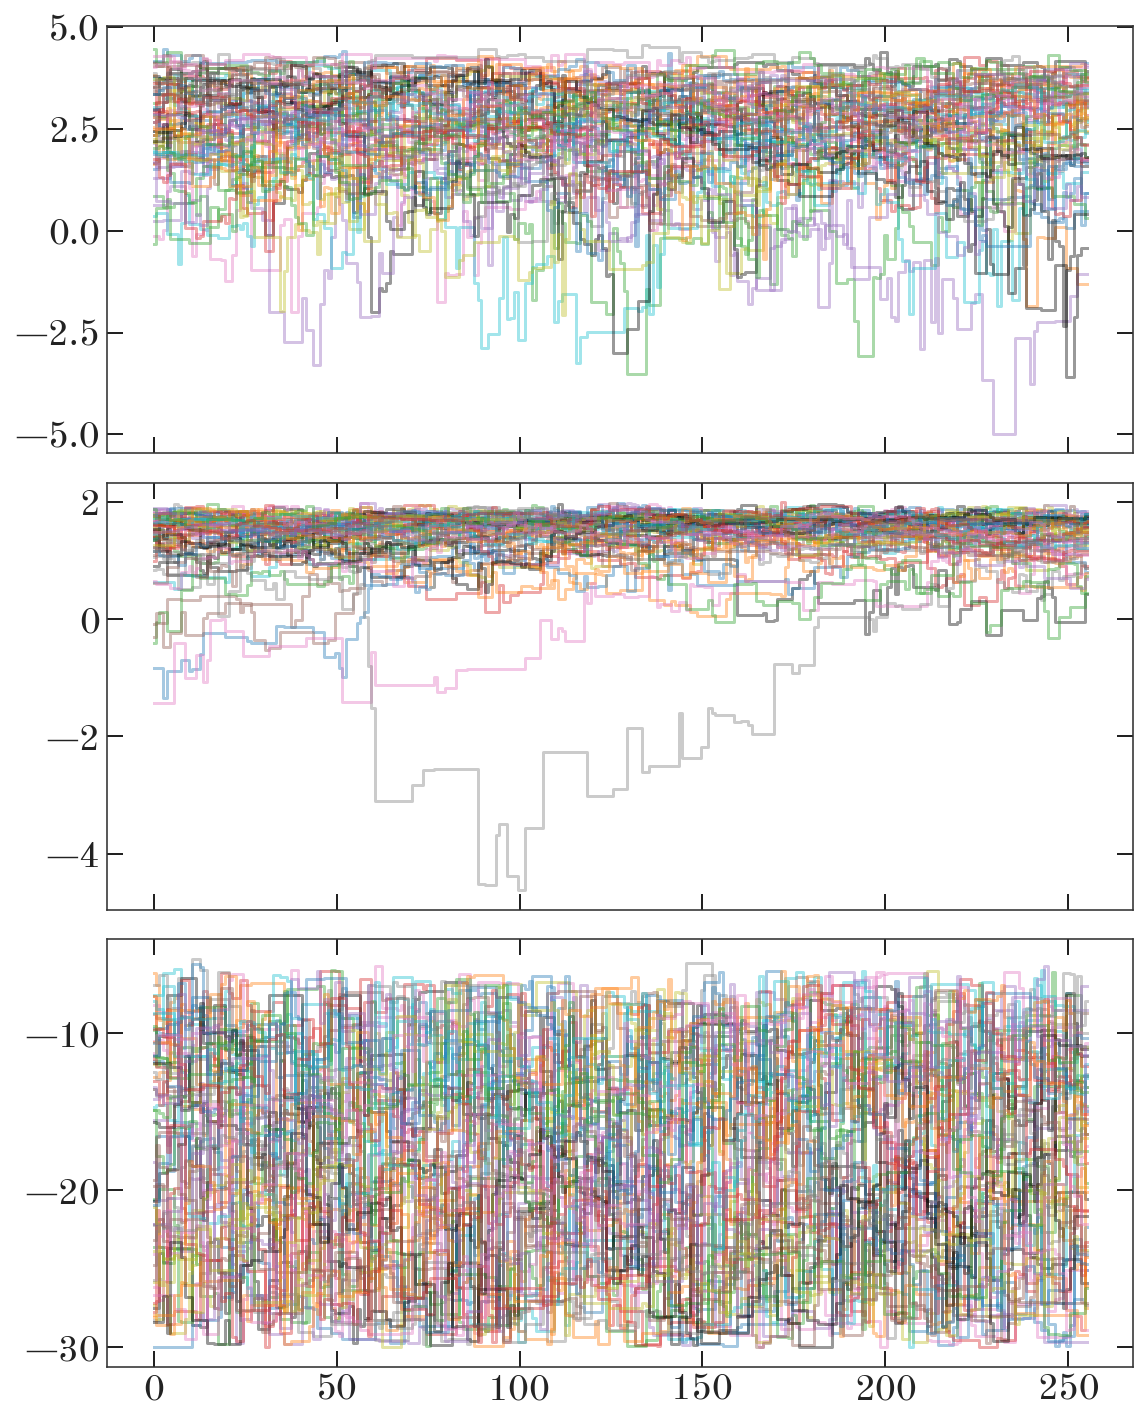

In [44]:
fig, axes = plt.subplots(ndim, 1, figsize=(8, 10), sharex=True)
for k in range(ndim):
    ax = axes[k]
    for walker in sampler.chain[..., k]:
        ax.plot(walker, drawstyle='steps-mid', marker='', alpha=0.4)
fig.tight_layout()

In [45]:
def get_orbit(x):
    fit_args = np.exp(x)

    integrator = gi.DOPRI853Integrator(F, func_units=galactic, func_args=fit_args)
    fit_orbit_drag = integrator.run(both_w0, dt=5, t1=-age, t2=0)[:, 0]
    
    return fit_orbit_drag

def get_orbit_c(x):
    fit_orbit_drag = get_orbit(x)
    fit_orbit_drag_c = fit_orbit_drag.to_coord_frame(gc.MagellanicStreamNidever08, 
                                                     galactocentric_frame=galcen_frame)
    
    return fit_orbit_drag_c

In [46]:
for i in range(sampler.chain[:, -1].shape[0]):
    tbl = Table()
    fit_orbit_drag_c = get_orbit_c(sampler.chain[i, -1])
    tbl['L'] = fit_orbit_drag_c.L
    tbl['B'] = fit_orbit_drag_c.B
    tbl['distance'] = fit_orbit_drag_c.distance
    tbl['vlsr'] = fit_orbit_drag_c.radial_velocity - 4*u.km/u.s
    tbl.write('../data/mcmc-orbit-{}.fits'.format(i), overwrite=True)

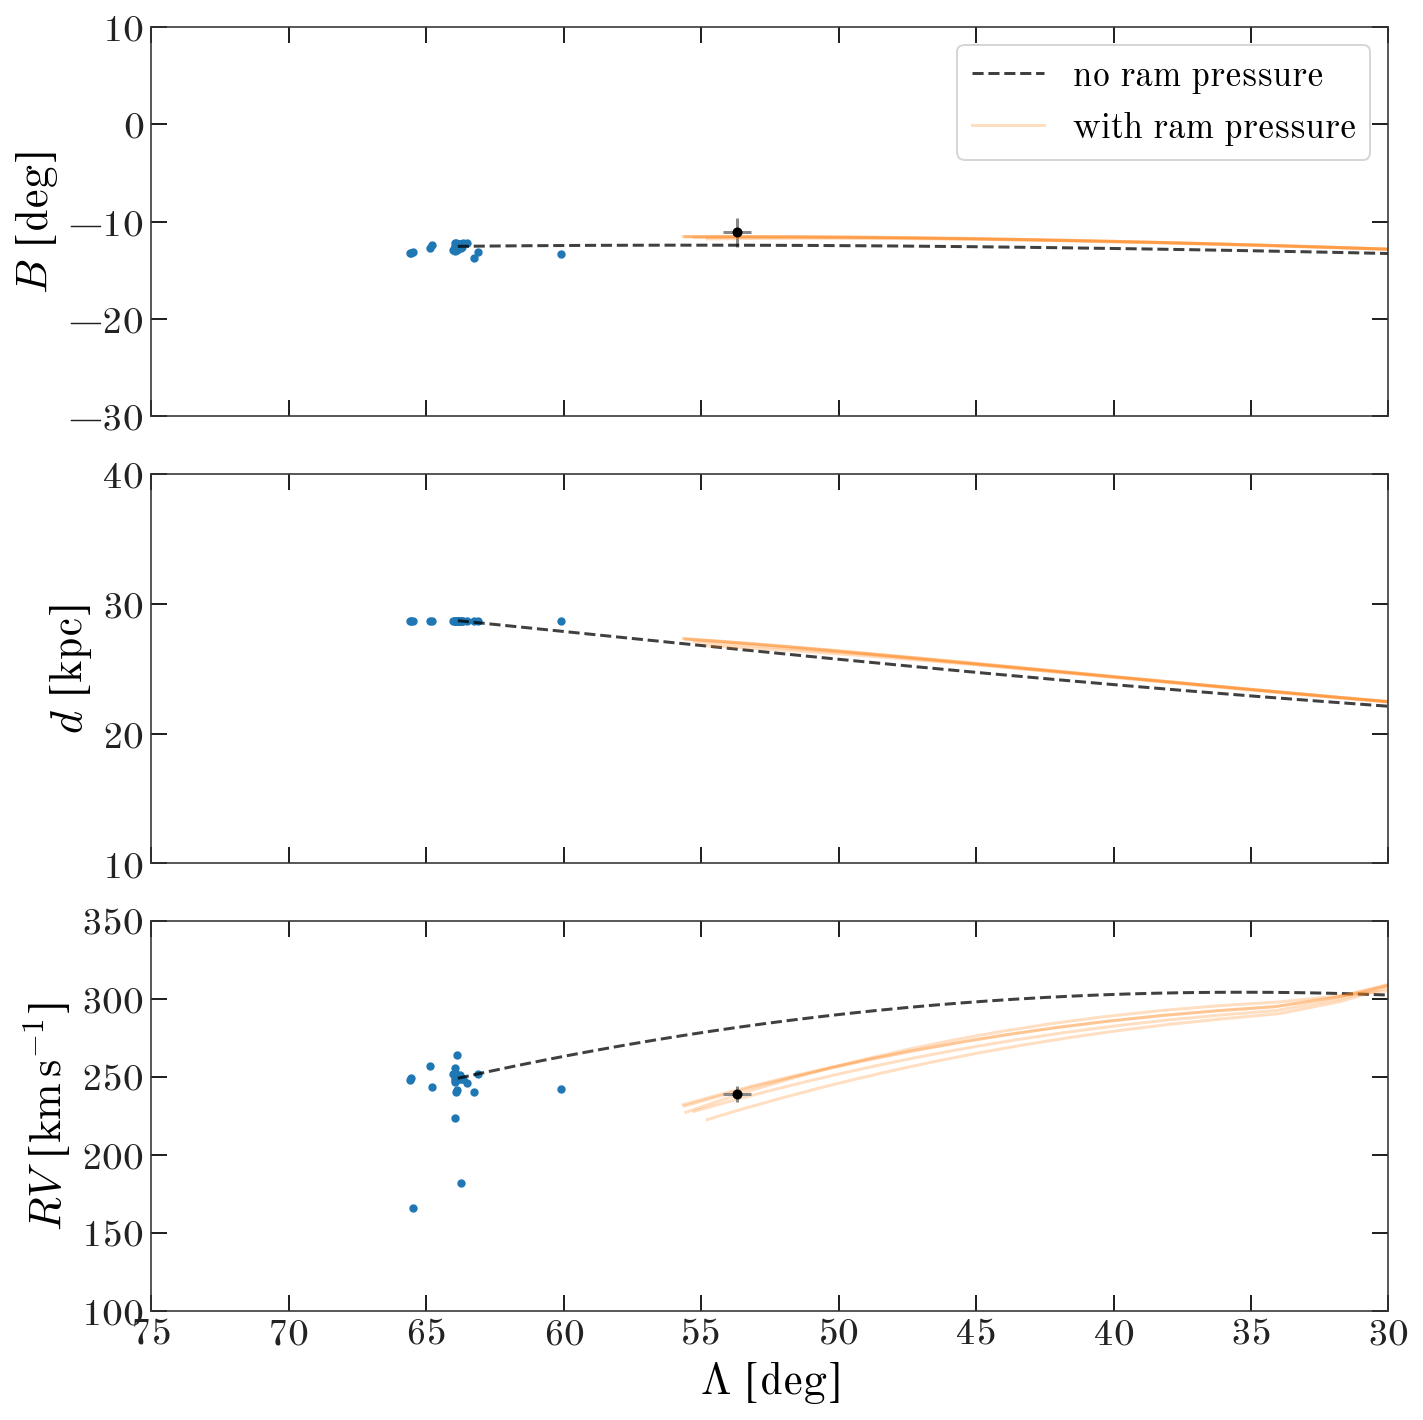

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True)

ax = axes[0]
mag_all_c = all_c.transform_to(gc.MagellanicStreamNidever08)
ax.scatter(mag_all_c.L.degree, mag_all_c.B.degree, 
           marker='o', color='tab:blue', s=10)

ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.B.degree, 
        marker='', ls='--', alpha=0.75, label='no ram pressure')

ax.set_xlim(75, 30)
ax.set_ylim(-30, 10)

ax.errorbar(L_fiducial, B_fiducial,
            xerr=L_sigma, yerr=B_sigma,
            marker='o', ls='none', 
            color='k', ecolor='#888888')

ax.set_ylabel(r'$B$ [deg]')

# ---

ax = axes[1]
ax.scatter(mag_all_c.L.degree, mag_all_c.distance.value, 
           marker='o', color='tab:blue', s=10)
ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.distance.value, 
        marker='', ls='--', alpha=0.75)

ax.set_xlim(75, 30)
ax.set_ylim(10, 40)

# ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$d$ [kpc]')

# ---

ax = axes[2]
ax.scatter(mag_all_c.L.degree, mag_all_c.radial_velocity.value, 
           marker='o', color='tab:blue', s=10)
ax.plot(orbit_nodrag_c.L.degree, orbit_nodrag_c.radial_velocity.value, 
        marker='', ls='--', alpha=0.75)

ax.errorbar(L_fiducial, rv_fiducial,
            xerr=L_sigma, yerr=rv_sigma,
            marker='o', ls='none', 
            color='k', ecolor='#888888',
            zorder=100)

# plot orbits
for i in range(sampler.chain[:, -1].shape[0]):
    if i == 0:
        label = 'with ram pressure'
    else:
        label = None
        
    fit_orbit_drag_c = get_orbit_c(sampler.chain[i, -1])
    axes[0].plot(fit_orbit_drag_c.L.degree, fit_orbit_drag_c.B.degree, 
                 marker='', alpha=0.25, color='tab:orange',
                 label=label)
    axes[1].plot(fit_orbit_drag_c.L.degree, fit_orbit_drag_c.distance.value, 
                 marker='', alpha=0.25, color='tab:orange')
    axes[2].plot(fit_orbit_drag_c.L.degree, fit_orbit_drag_c.radial_velocity.value, 
                 marker='', alpha=0.25, color='tab:orange')
    
    if i >= 4:
        break

axes[0].legend(loc='best', fontsize=18)
    
ax.set_xlim(75, 30)
ax.set_ylim(100, 350)

ax.set_xlabel(r'$\Lambda$ [deg]')
ax.set_ylabel(r'$RV$ [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()
# fig.savefig('../plots/orbit-fits-ram-press.png', dpi=250)

In [48]:
flatchain = np.vstack(sampler.chain[:, ::1]).T
f_halos, f_disks, couplings  = np.exp(flatchain)

In [49]:
import corner

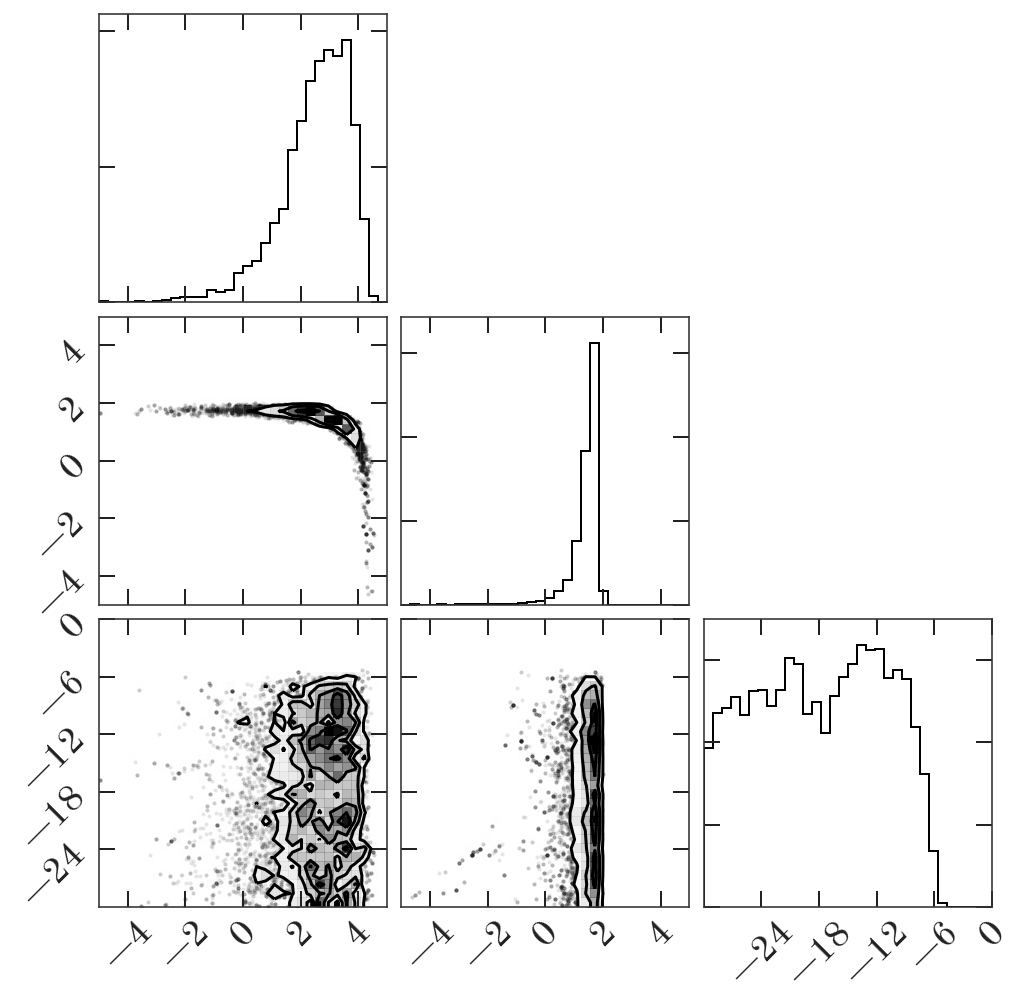

In [51]:
fig = corner.corner(flatchain.T, range=bounds, bins=32)

In [53]:
nhalo17 = f_halos * n_mw_halo(17.) # / 1e-3
ndisk20 = f_disks * n_mw_disk(20., 0) # / 1e-1

In [54]:
x = np.percentile(nhalo17, [16, 50, 84])
x[1], x[1]-x[0], x[2]-x[1]

(0.0017673204427498695, 0.0012800804640901702, 0.0027396927056656177)

$$1.8_{-1.3}^{+2.7} \times 10^{-3}~{\rm atoms}~{\rm cm}^{-2}$$

In [56]:
x = np.percentile(ndisk20, [16, 50, 84])
x[1], x[1]-x[0], x[2]-x[1]

(0.09823359320156931, 0.03535260508113437, 0.01971568039306494)

$$9.8_{-3.5}^{+2.0} \times 10^{-2}~{\rm atoms}~{\rm cm}^{-2}$$

In [57]:
n_mw_halo(17.)

0.00011764420865444278

In [58]:
n_mw_disk(20., 0.)

0.02058611842011501

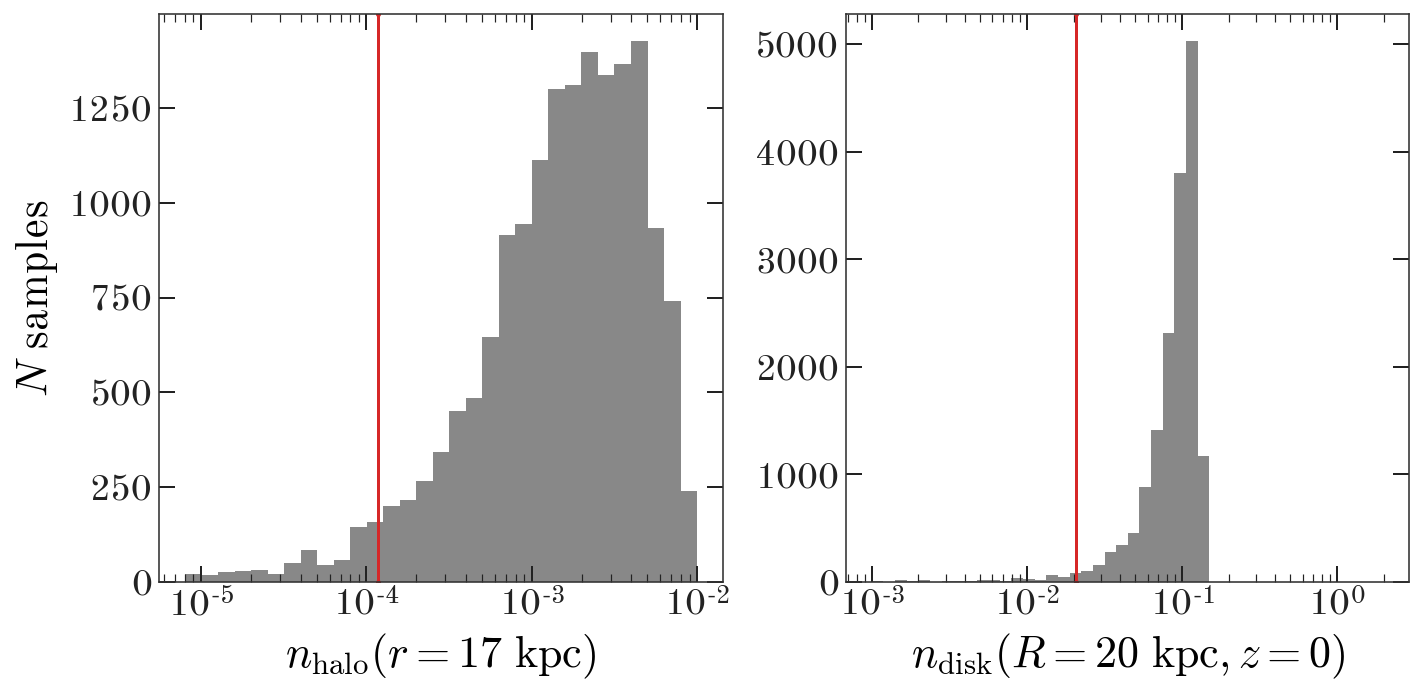

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(nhalo17, bins=np.geomspace(8e-6, 1e-2, 32), 
             color='#888888', rasterized=True);
axes[0].set_xscale('log')
axes[0].axvline(n_mw_halo(17.), color='tab:red')
axes[0].set_xticks(10**np.arange(-5, -2+1e-3, 1))
axes[0].set_xlabel(r'$n_{\rm halo}(r=17~{\rm kpc})$')
axes[0].set_ylabel('$N$ samples')

axes[1].hist(ndisk20, bins=np.geomspace(1e-3, 2e0, 45), 
             color='#888888', rasterized=True);
axes[1].set_xscale('log')
axes[1].axvline(n_mw_disk(20., 0), color='tab:red')
axes[1].set_xlabel(r'$n_{\rm disk}(R=20~{\rm kpc}, z=0)$')

fig.tight_layout()
fig.savefig('../plots/nhalo_ndisk.pdf')

In [215]:
get_orbit(flatchain[:, 0]).spherical.distance.min()

<Distance 16.77769929 kpc>

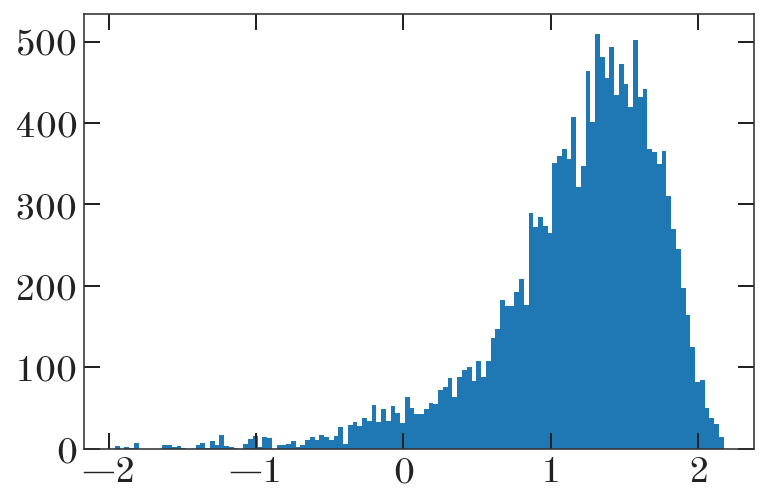

In [216]:
plt.hist(np.log10(f_halos), bins=128);

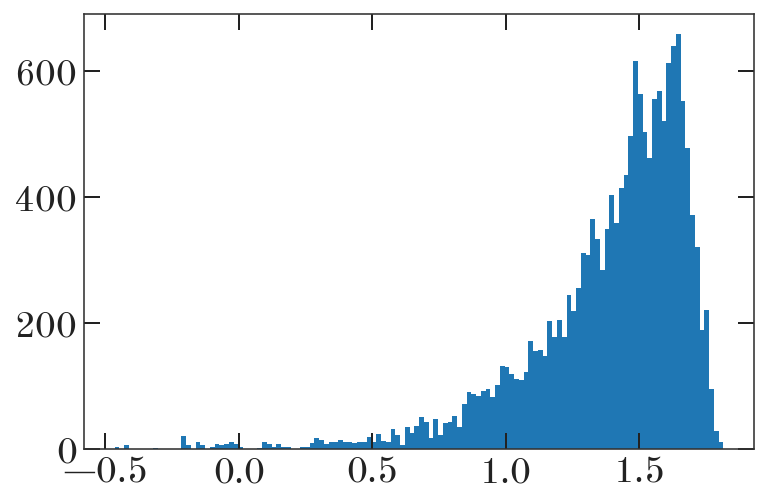

In [217]:
plt.hist(np.log10(f_disks), bins=128);

In [221]:
# transformed
trans_flatchain = np.stack((f_halos, #* n_mw_halo(17.) / 1e-3,
                            f_disks, #* n_mw_disk(20., 0) / 1e-1,
                            np.log10(couplings),
                            np.log10(surf_dens0s))).T

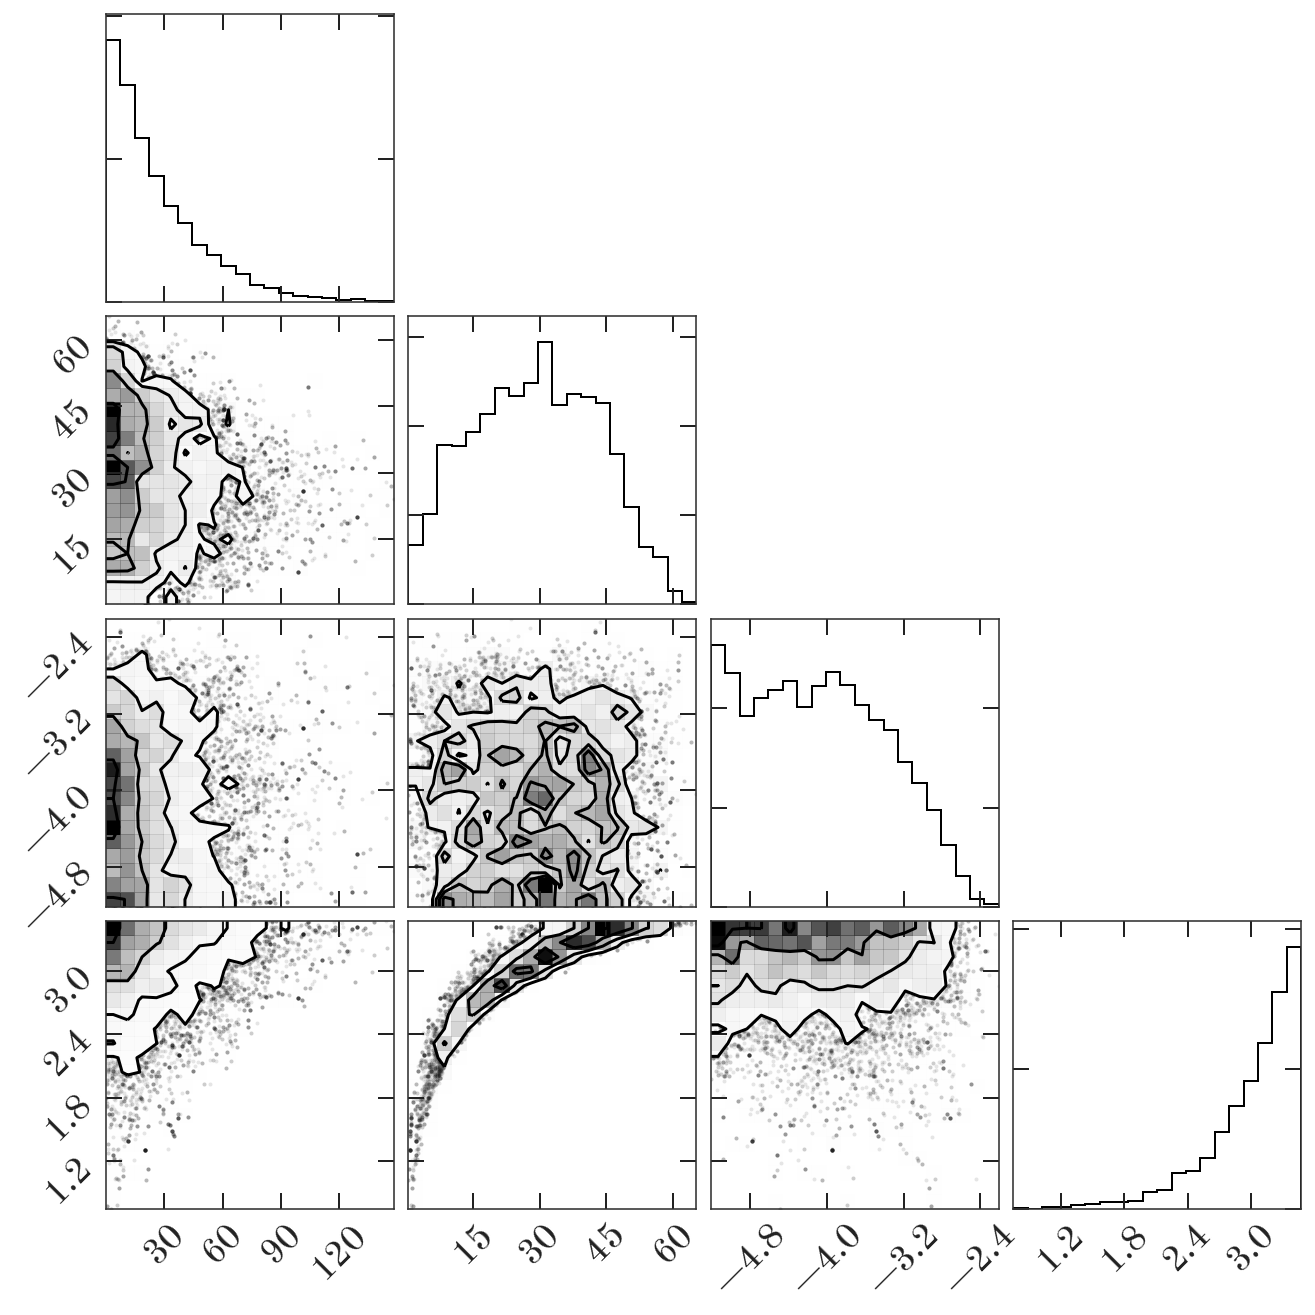

In [222]:
_ = corner.corner(trans_flatchain) #, range=bounds)